In [14]:
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV

In [15]:
df=pd.read_csv("term-deposit-marketing-2020.csv",sep=',')
df=df.drop(['duration'],axis=1)
print(df.shape)

df.info()
df.head()

(40000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
age          40000 non-null int64
job          40000 non-null object
marital      40000 non-null object
education    40000 non-null object
default      40000 non-null object
balance      40000 non-null int64
housing      40000 non-null object
loan         40000 non-null object
contact      40000 non-null object
day          40000 non-null int64
month        40000 non-null object
campaign     40000 non-null int64
y            40000 non-null object
dtypes: int64(4), object(9)
memory usage: 4.0+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,no


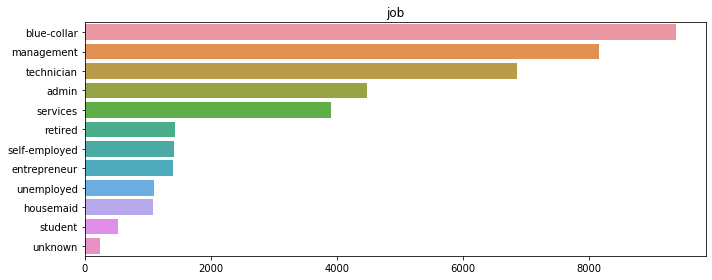

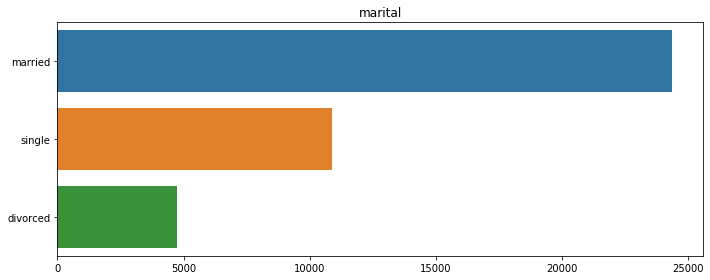

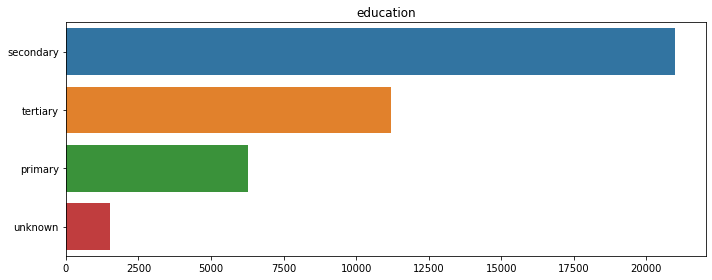

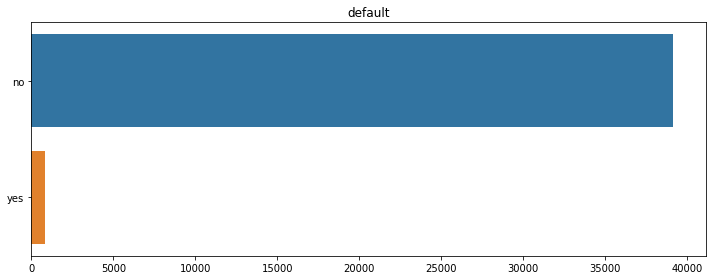

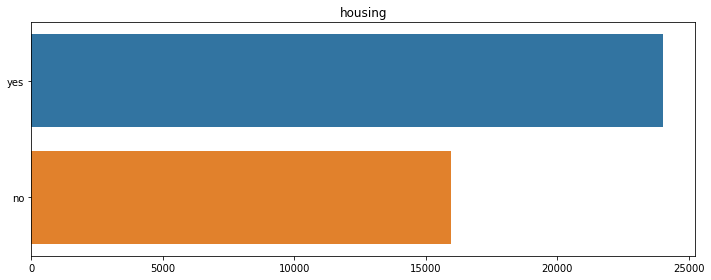

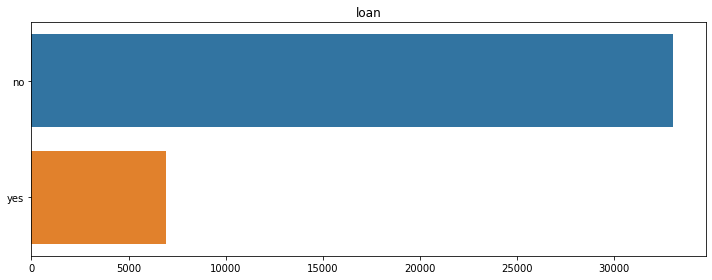

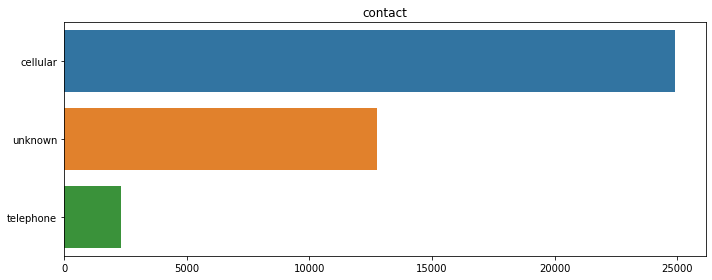

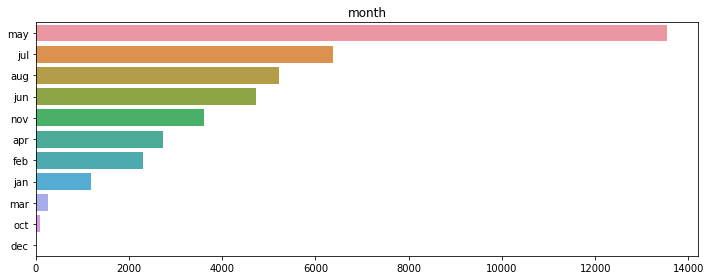

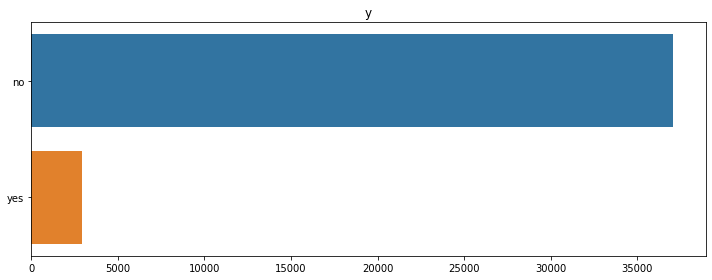

In [16]:
categorcial_variables = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month', 'y']
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()



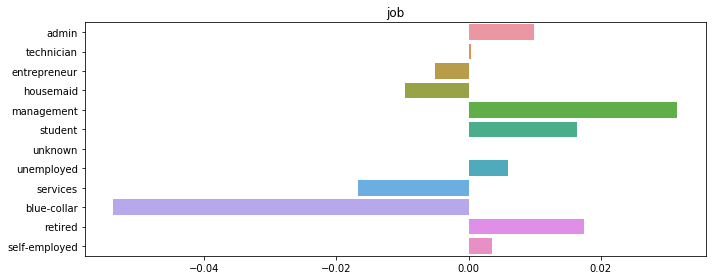

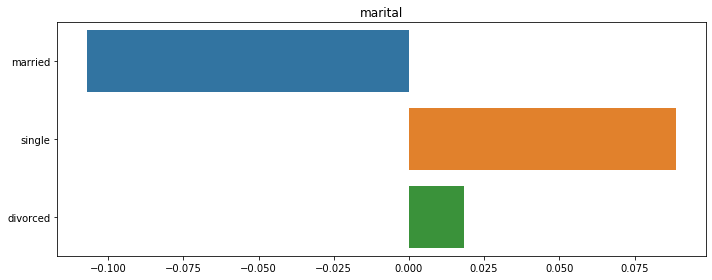

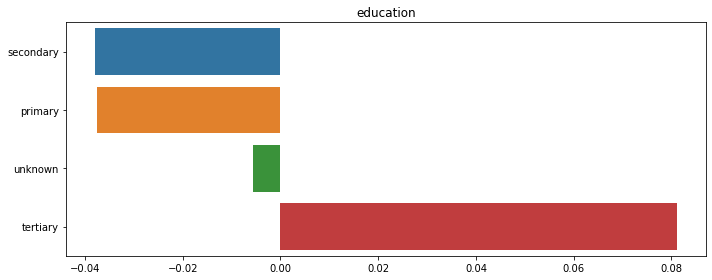

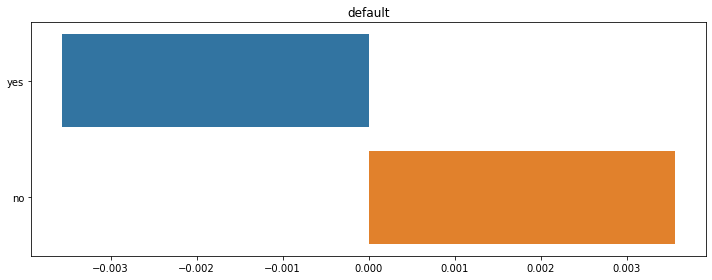

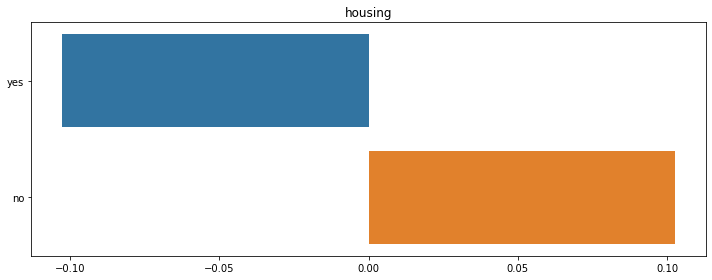

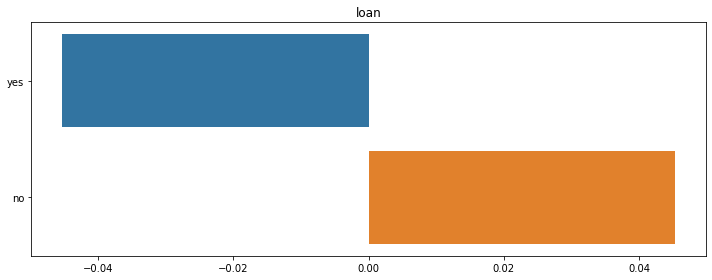

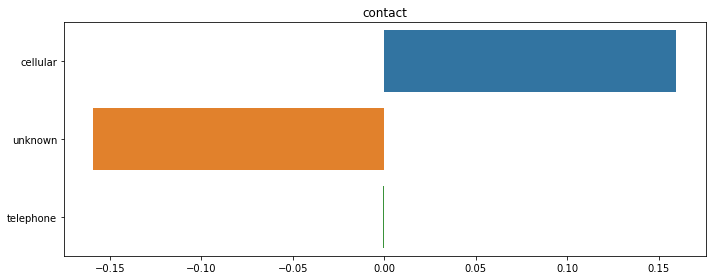

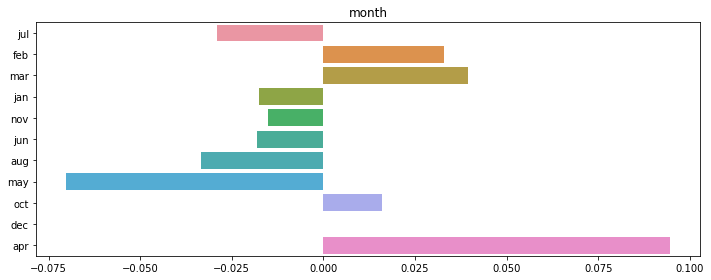

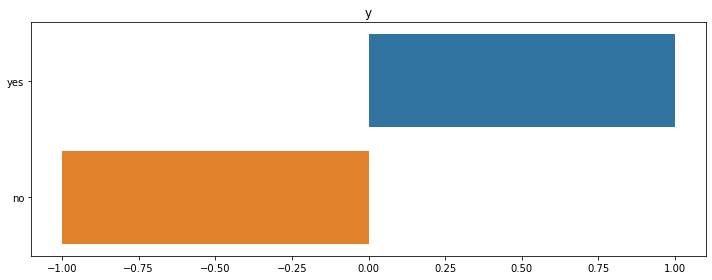

In [17]:
categorcial_variables = ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month', 'y']
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    #Returns counts of unique values for each outcome for each feature.
    pos_counts = df.loc[df.y.values == 'yes', col].value_counts() 
    neg_counts = df.loc[df.y.values == 'no', col].value_counts()
    
    all_counts = list(set(list(pos_counts.index) + list(neg_counts.index)))
    
    #Counts of how often each outcome was recorded.
    freq_pos = (df.y.values == 'yes').sum()
    freq_neg = (df.y.values == 'no').sum()
    
    pos_counts = pos_counts.to_dict()
    neg_counts = neg_counts.to_dict()
    
    all_index = list(all_counts)
    all_counts = [pos_counts.get(k, 0) / freq_pos - neg_counts.get(k, 0) / freq_neg for k in all_counts]

    sns.barplot(all_counts, all_index)
    plt.title(col)
    plt.tight_layout()

In [18]:
## Creating new variables (variable name + '_un') to capture the information if the missing values are at random or is there
## a pattern in the missing values.
significant_cat_variables = ['education','job','housing','loan']
for var in significant_cat_variables:
    #df[var + '_un'] = 0
    #df[var + '_un'][df[var]=='unknown'] = 1
    #FIXME one-line coding
    df[var + '_un'] = (df[var] == 'unknown').astype(int)

In [19]:
def cross_tab(df,f1,f2):
    jobs=list(df[f1].unique())
    edu=list(df[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=df[df[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx



In [20]:
cross_tab(df,'job','education')

,tertiary,secondary,unknown,primary
job,,,,
admin,410,3723,148,202
blue-collar,127,5144,439,3673
entrepreneur,648,507,74,176
housemaid,147,345,40,555
management,6667,1037,189,273
retired,229,664,59,485
self-employed,702,552,31,129
services,170,3269,135,336
student,150,282,74,18


In [21]:
df['job'][df['age']>60].value_counts()

retired          163
management        22
housemaid         15
technician        10
blue-collar        8
self-employed      6
admin              4
unknown            3
unemployed         2
entrepreneur       1
Name: job, dtype: int64

In [23]:
df.loc[(df['age']>60) & (df['job']=='unknown'), 'job'] = 'retired'
df.loc[(df['education']=='unknown') & (df['job']=='management'), 'education'] = 'tertiary'
df.loc[(df['education']=='unknown') & (df['job']=='services'), 'education'] = 'secondary'
df.loc[(df['job'] == 'unknown') & (df['education']=='primary'), 'job'] = 'blue-collar'

In [24]:
cross_tab(df,'job','education')

,tertiary,secondary,unknown,primary
admin,410,3723,148.0,202.0
blue-collar,127,5144,439.0,3718.0
entrepreneur,648,507,74.0,176.0
housemaid,147,345,40.0,555.0
management,6856,1037,0.0,273.0
retired,230,665,60.0,485.0
self-employed,702,552,31.0,129.0
services,170,3404,0.0,336.0
student,150,282,74.0,18.0
technician,1702,4788,214.0,148.0


In [25]:
jobhousing=cross_tab(df,'job','housing')
jobloan=cross_tab(df,'job','loan')

In [29]:
def fillhousing(df,jobhousing):
    """Function for imputation via cross-tabulation to fill missing values for the 'housing' categorical feature"""
    jobs=['housemaid','services','admin','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    house=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['housing']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobhousing.loc[j]['no'])/(jobhousing.loc[j]['no']+jobhousing.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"housing"]='no'
        df.loc[ind2,"housing"]='yes'
    return df

In [30]:
def fillloan(df,jobloan):
    """Function for imputation via cross-tabulation to fill missing values for the 'loan' categorical feature"""
    jobs=['housemaid','services','admin','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    loan=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['loan']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobloan.loc[j]['no'])/(jobloan.loc[j]['no']+jobloan.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"loan"]='no'
        df.loc[ind2,"loan"]='yes'
    return df



In [31]:
df=fillhousing(df,jobhousing)

df=fillloan(df,jobloan)

In [32]:
numerical_variables = ['age','campaign', 'day', 'balance']
df[numerical_variables].describe()

,age,campaign,day,balance
count,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,2.882175,16.017225,1274.277550
std,9.641776,3.239051,8.278127,2903.769716
min,19.000000,1.000000,1.000000,-8019.000000
25%,33.000000,1.000000,8.000000,54.000000
50%,39.000000,2.000000,17.000000,407.000000
75%,48.000000,3.000000,21.000000,1319.000000
max,95.000000,63.000000,31.000000,102127.000000


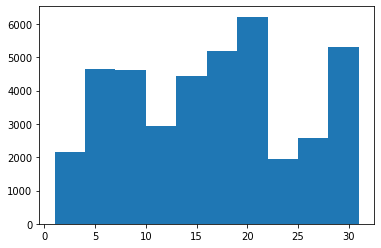

In [34]:
def drawhist(df,feature):
    plt.hist(df[feature])


drawhist(df,'day')
plt.show()


In [35]:
def dropfeature(df,f):
    """Drops one of the dummy variables."""
    df=df.drop(f,axis=1)
    return df

In [39]:
df_dropped_pdays = df.drop('day', axis=1);
df_with_dummies=pd.get_dummies(df_dropped_pdays)
features_dropped = ['default_no','housing_no','loan_no','y_no','marital_single','contact_cellular',
                    'education_unknown','job_unknown']
df_clean = dropfeature(df_with_dummies, features_dropped)

In [41]:
def drawheatmap(df):
    '''Builds the heat map for the given data'''
    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(df.corr(method='spearman'), annot=False, cmap='coolwarm')
    
def drawhist(df,feature):
    '''Draws an histogram for a feature in a data frame (df)'''
    plt.hist(df[feature])

def functionreplace(df,fea,val1,val2):
    '''Replaces value (val1) with value (val2) in the data frame (df) for a feature (fea)'''
    df[fea].replace(val1,val2)
    return df

def drawbarplot(df,x,y):
    '''Draws a bar plot for a given feature x and y in a data frame'''
    sns.barplot(x=x, y=y, data=df)

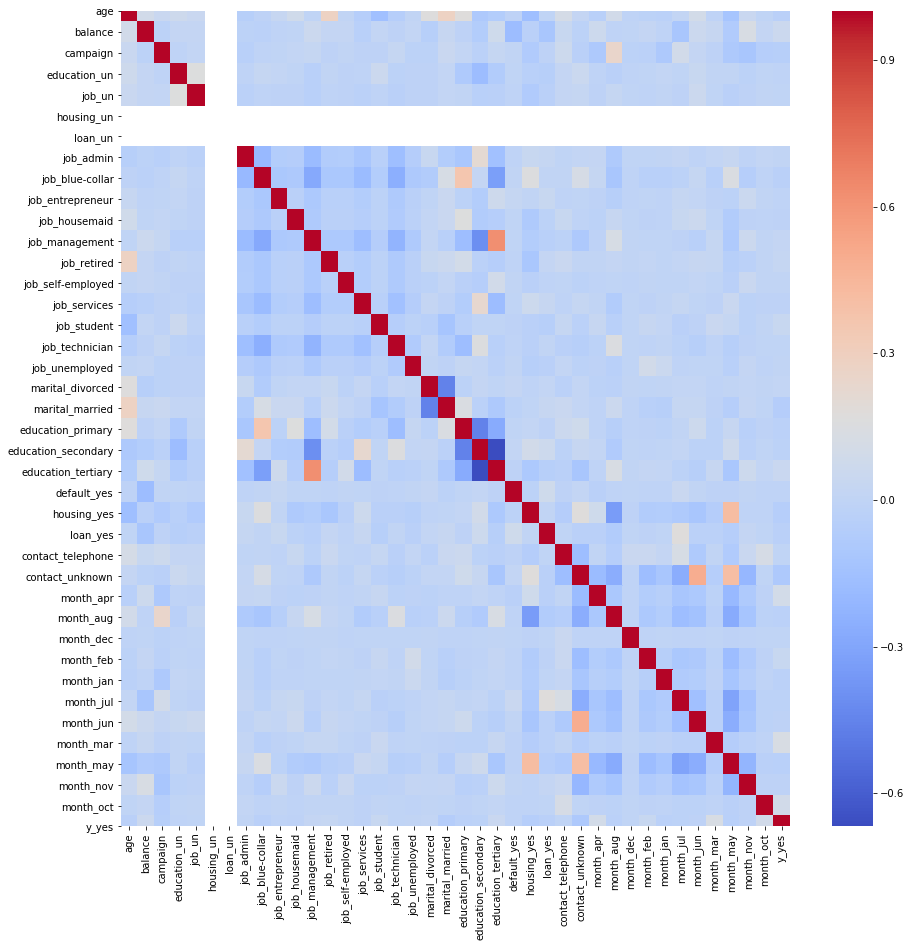

In [42]:
drawheatmap(df_clean)

In [43]:
def getmeanauc(aucs,model):
    ''' Calculates the mean AUC for all the cross-validated samples and computes the value of C (Regularization Parameter) 
    for which max mean auc is obtained'''
    #Initialize empty array to hold mean AUC values.
    meanauc = []
    maxmean = 0 #Initial value for maximum mean AUC
    models_with_1_param = ['Logistic_Regression' , 'Ada_Boost']
    models_with_2_params = ['Decision_Tree' , 'Random_Forest', 'Grad_Boost']
    for c in aucs: #For loop to append AUC value to meanauc array.
        meanauc.append(np.mean(aucs[c]))
        if maxmean < np.mean(aucs[c]):
            maxmean = np.mean(aucs[c]) #Adjust value of maxmean
            cval = c
    if model in models_with_1_param:
        print("C value for max auc is: ",cval)
        print("Max Mean Auc corresponding to the optimal value of C = ", maxmean)
        return meanauc,cval
    if model in models_with_2_params:
        listSL=cval.split('L')
        splitval=int(listSL[0]) #Stores minimum split value for max AUC
        leafval=int(listSL[1]) #Stores minimum leaf value for max AUC
        print("min_sample_split value for max auc is:",splitval)
        print("min_sample_leaf value for max auc is:",leafval)
        print("Max mean AUC corresponding to optimal leaf and split value = ",maxmean)
        return meanauc,splitval,leafval

def plot_mean_auc_LR(aucs,cs, label):
    '''Plots different values of mean auc versus the hyperparameter C'''
    plt.plot(np.log10(cs),aucs, label = label )
    plt.xlabel("C (Regularization Parameter)")
    plt.ylabel("Mean AUC")
    plt.legend()
        
def plotfeatureimportances(train, importance):
    '''Plots feature importance in a sorted order and shows the most significant variables at the top'''
    X = list(train.columns)
    X.remove('y_yes')
    feature_importance_df = pd.DataFrame(data = importance, index = X, columns=['coefficient_values'])
    feature_importance_df['sort'] = feature_importance_df.coefficient_values.abs()
    sorted_feature_imp_df = feature_importance_df.sort_values(by='sort', ascending=False).drop('sort', axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 15)
    sns.barplot(np.array(sorted_feature_imp_df.coefficient_values), np.array(sorted_feature_imp_df.index.values))
    plt.title('Feature Importances')
    plt.xlabel('Coefficients')
    plt.ylabel('Feature Names')
    
def plotfeatureimp(fl,col):
    '''Plots the feature importance of all the independent variables in the model'''
    f=plt.figure(figsize=(10,15))
    plt.barh(range(len(fl)),fl)
    plt.yticks(range(len(col[:-1])),col[:-1])
    
def plotAUCDTRF(aucs,leafs,splits):
    '''Plots AUC for each value of Leaf and Split combination'''
    for i in range(len(splits)):
        plt.plot(leafs,aucs[len(leafs)*i:len(leafs)*i+len(leafs)], label = 'Split value= ' + str(splits[i]))
    plt.legend()
    plt.xlabel('Leaf Values')
    plt.ylabel('Mean AUC')
    
def plot_mean_auc_Ada_Boost(aucs, estimators, label):
    '''Plots different values of mean auc versus the Estimators for AdaBoosting'''
    plt.plot(estimators,aucs, label = label )
    plt.xlabel("Estimators")
    plt.ylabel("Mean AUC")
    plt.legend()

In [44]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_clean, train_size=0.8, random_state=5)
print('Original:', (df_clean.y_yes).mean(), 'Train:', (train.y_yes).mean(), 'Test:', (test.y_yes).mean())

train, test = train_test_split(df_clean, train_size=0.8, stratify=df_clean.y_yes.values, random_state=5)
print('Original:', (df_clean.y_yes).mean(), 'Train:', (train.y_yes).mean(), 'Test:', (test.y_yes).mean())



Original: 0.0724 Train: 0.0709375 Test: 0.07825
Original: 0.0724 Train: 0.07240625 Test: 0.072375


In [51]:
from sklearn.ensemble import AdaBoostClassifier

In [75]:
from sklearn.ensemble import GradientBoostingClassifier
def GBoosting(train,validation,leaf=1,split=2):
    """Function for gradient boosting to minimize loss via weak learners"""
    X=list(train.columns)
    Y='y_yes'
    X.remove('y_yes')
    xtrain=train[X]
    ytrain=train[Y]
    xval=validation[X]
    yval=validation[Y]
    
    GB = GradientBoostingClassifier(min_samples_split=split,min_samples_leaf=leaf)
    
    #Train the model
    GB.fit(xtrain,ytrain)
    
    #Predict target values
    Y_pred = GB.predict(xval)
    
    #Predict class probabilities of input validation data
    gbplot=GB.predict_proba(xval)
    gbpre=gbplot[:,1]
    
    #Compute ROC
    gbfpr, gbtpr, gbthresholds=metrics.roc_curve(yval,gbpre)
    
    #Compute ROC AUC scores from prediction values
    gbscore=metrics.roc_auc_score(yval,gbpre)
    gbaccuracy=metrics.accuracy_score(yval,GB.predict(xval))
    
    #Feature importances. The higher the score, the more important the feature. 
    importance=GB.feature_importances_
    
    return gbscore,importance,gbtpr,gbfpr,gbthresholds,gbaccuracy

In [110]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import preprocessing
def kfoldGB(dataset, k,split,leaf):
    aucs={}
    kf=KFold(k,shuffle = True) #Provides indices to split data in train/test sets
    for sp in split:
        for lf in leaf:
            for train_idx, vali_idx in kf.split(dataset):
                cv_train,cv_validate=dataset.iloc[train_idx,:], dataset.iloc[vali_idx,:]
                #Run Gradient Boosted Trees function defined above based on user input
                gbscore,importance,gbtpr,gbfpr,gbthresholds,gbaccuracy= GBoosting(cv_train,cv_validate,lf,sp)
                
                #Storing the AUC scores in the aucs dictionary for all split values (sp) and leaf values (lf)
                if str(sp)+"L"+str(lf) in aucs:
                    aucs[str(sp)+"L"+str(lf)].append(gbscore)
                else:
                    aucs[str(sp)+"L"+str(lf)]=[]
                    aucs[str(sp)+"L"+str(lf)].append(gbscore)
    return aucs

min_sample_split value for max auc is: 85
min_sample_leaf value for max auc is: 13
Max mean AUC corresponding to optimal leaf and split value =  0.703321037290326


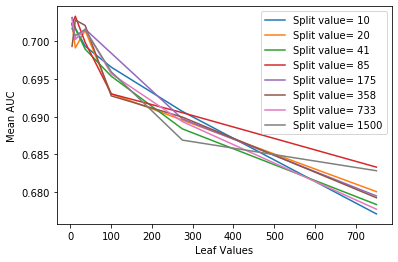

In [111]:
gbsplit = np.geomspace(10,1500, num=8, dtype=int)
gbleaf = np.geomspace(5,750, num=6, dtype=int)
gbaucs=kfoldGB(train,5,gbsplit,gbleaf)

gbauc,gbsplitval,gbleafval=getmeanauc(gbaucs,'Grad_Boost')
plotAUCDTRF(gbauc,gbleaf,gbsplit)

